# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
!pip install scikit-learn==1.1.3

     |████████████████████████████████| 30.8 MB 47 kB/s  eta 0:00:01     |████████████████████████████▉   | 27.7 MB 2.5 MB/s eta 0:00:02
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
import numpy as np 
import pandas as pd  
import time
import warnings

from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression 

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import cross_val_score, GridSearchCV , RandomizedSearchCV, train_test_split 
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error 
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

warnings.filterwarnings("ignore")

RND = 12345

In [3]:
data = pd.read_csv('/datasets/autos.csv')

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
def columns(data):
    for column in data.columns:
        print(column)
        print(data[column].unique())

In [7]:
columns(data)

DateCrawled
['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']
Price
[  480 18300  9800 ... 12395 18429 10985]
VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
RegistrationYear
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 1938 1688 2800
 1253 1928 1919 5555 5600 1600 2222 1039 9996 1300 8455 1931 

Заменим пропуски на соответствующее значение столбца unknown или other

In [8]:
data['Gearbox'] = data['Gearbox'].fillna('unknown')
data['Repaired'] = data['Repaired'].fillna('unknown')
data['Model'] = data['Model'].fillna('other')
data['VehicleType'] = data['VehicleType'].fillna('other')
data['FuelType'] = data['FuelType'].fillna('other')

Удалим столбцы ненужные нам для обучения модели

In [9]:
data = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [10]:
data.duplicated().sum()

27650

In [11]:
data = data.drop_duplicates()
data.duplicated().sum()

0

Проверим что пропусков не осталось

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326719 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              326719 non-null  int64 
 1   VehicleType        326719 non-null  object
 2   RegistrationYear   326719 non-null  int64 
 3   Gearbox            326719 non-null  object
 4   Power              326719 non-null  int64 
 5   Model              326719 non-null  object
 6   Kilometer          326719 non-null  int64 
 7   RegistrationMonth  326719 non-null  int64 
 8   FuelType           326719 non-null  object
 9   Brand              326719 non-null  object
 10  Repaired           326719 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.9+ MB


Посмотрим столбец Price

<AxesSubplot:>

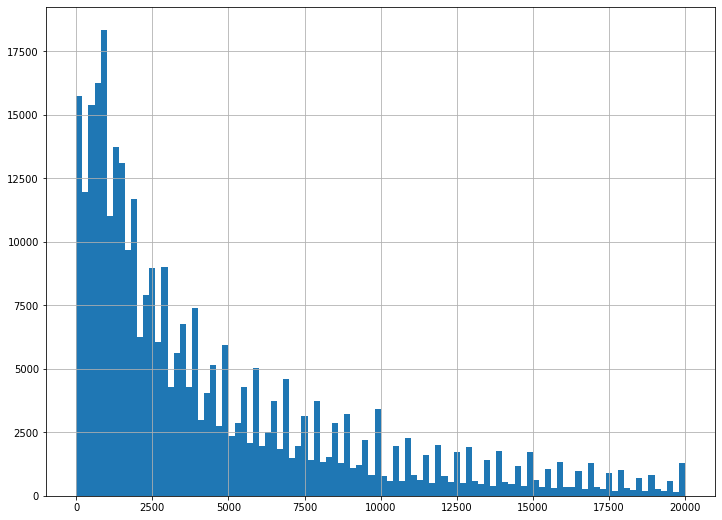

In [13]:
data['Price'].hist(bins=100, figsize=(12,9))

In [14]:
data['Price'].quantile(.05)

200.0

5% квантиль 200 евро, отсечем все цены дешевле 200

In [15]:
data = data.query('Price>200')

Посмотрим столбец RegistrationYear

<AxesSubplot:>

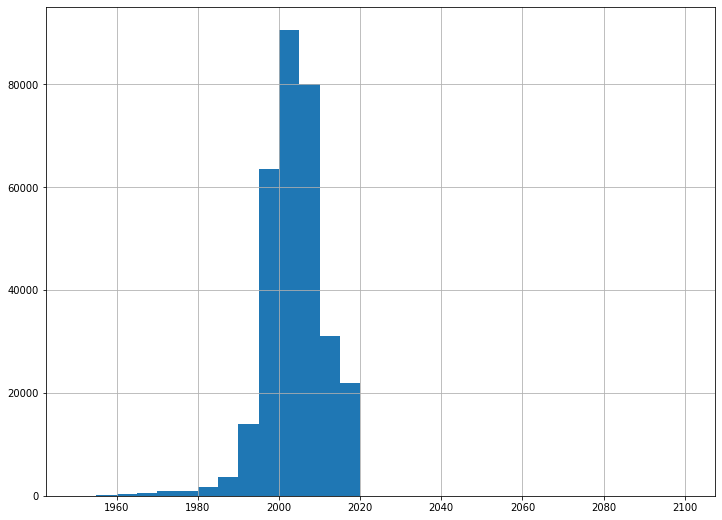

In [16]:
data['RegistrationYear'].hist(bins=30, figsize=(12,9), range=(1950, 2100))

In [17]:
data['RegistrationYear'].describe()

count    309119.000000
mean       2003.980949
std          69.369146
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Отбросим года больше 2016 и меньше 1970

In [18]:
data = data.query('1970 < RegistrationYear < 2016')

In [19]:
data['RegistrationYear'].describe()

count    286835.000000
mean       2002.452086
std           6.031449
min        1971.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2015.000000
Name: RegistrationYear, dtype: float64

Посмотрим столбец Power

<AxesSubplot:>

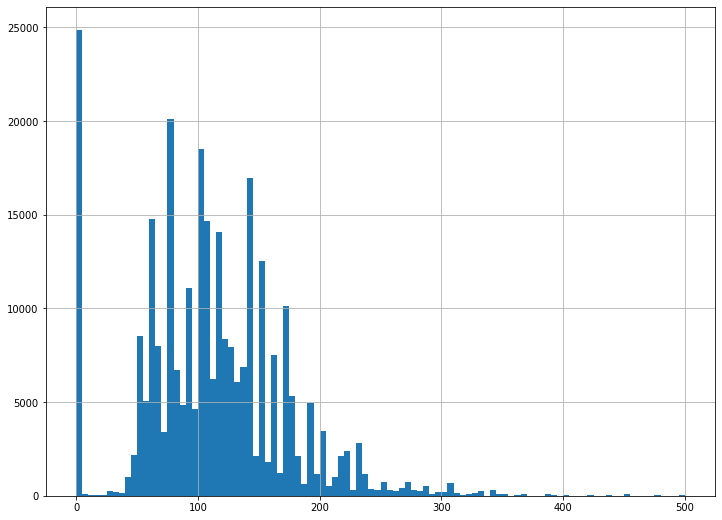

In [20]:
data['Power'].hist(bins=100, figsize=(12,9), range=(0, 500))

In [21]:
data['Power'].describe()

count    286835.000000
mean        114.474015
std         184.335281
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Отбросим машины мощьностью меньше 50 и больше 500

In [22]:
data = data.query('49 < Power < 500')

## Обучение моделей

Отдельное преобразование для RandomForestRegressor

In [23]:
features = data.drop('Price', axis=1)
target = data['Price']

In [24]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=RND)

In [25]:
#категориальные признаки для OHE RandomForestRegressor
ohe_features_rf = features_train.select_dtypes(include='object').columns.to_list()
ohe_features_rf.remove('Model')
ohe_features_rf

['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired']

In [26]:
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
#num_features.remove('Repaired')
num_features

['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

In [27]:
col_transformer_rf= make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='error'), ohe_features_rf),
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
        ['Model']
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough'
)

Преобразуем категориальные признаки в численные с помощью OHE и OE.

Отдельное преобразование для LinearRegression

In [181]:
features_lr = pd.get_dummies(features, drop_first=True)

In [182]:
features_train_lr, features_test_lr, target_train_lr, target_test_lr = train_test_split(features_lr, target, test_size=0.25, random_state=RND)

In [183]:
features_lr.head()

,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
1,2011,190,125000,5,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2004,163,125000,8,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,2001,75,150000,6,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,2008,69,90000,7,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,1995,102,150000,10,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


Отдельное преобразование для CatBoost и LGBM

In [28]:
features_train_oe, features_test_oe, target_train_oe, target_test_oe = train_test_split(features, target, test_size=0.25, random_state=RND)

In [29]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
columns = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired', 'Brand', 'Model']
#features_train_oe = features_train.copy()
features_train_oe[columns] = encoder.fit_transform(features_train_oe[columns])

features_test_oe[columns] = encoder.transform(features_test_oe[columns])

In [30]:
features_test_oe.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
41978,5.0,2009,0.0,71,106.0,70000,7,6.0,32.0,0.0
69835,4.0,2003,1.0,145,154.0,150000,8,6.0,10.0,2.0
315677,5.0,2002,1.0,75,75.0,150000,1,6.0,27.0,0.0
310483,1.0,2006,1.0,150,97.0,90000,3,6.0,38.0,0.0
145377,5.0,2006,1.0,109,8.0,150000,12,2.0,25.0,2.0


Для оценки качества моделей создадим функцию RMSE

In [33]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5
   
RMSE_score = make_scorer(RMSE, greater_is_better=False)

### LinearRegression

In [194]:
%%time
start = time.time()
model1 = LinearRegression()

model1.fit(features_train_lr, target_train)

end = time.time()
time_model1_fit = end - start

regression_cv_score = pd.Series(cross_val_score(model1, features_train_lr, target_train, scoring=RMSE_score, cv=3)).mean()*(-1)
print('Среднее качество модели линейной регрессии на кросс-валидации:', regression_cv_score)

Среднее качество модели линейной регрессии на кросс-валидации: 2449.411700744257
CPU times: user 33.3 s, sys: 15 s, total: 48.3 s
Wall time: 48.5 s


In [195]:
%%time
start = time.time()

model1_predict = model1.predict(features_test_lr)

end = time.time()
time_model1_predict = end - start

CPU times: user 128 ms, sys: 192 ms, total: 320 ms
Wall time: 302 ms


In [196]:
RMSE(target_test_lr, model1_predict)

2426.5329434612286

### RandomForestRegressor

In [218]:
%%time

model2 = RandomForestRegressor(random_state=RND)

pipline_rf = make_pipeline(col_transformer_rf, model2)

#model2_parametrs = { 'n_estimators': range(5, 15, 5),
#                     'max_depth': range(1, 6, 2),
#                     'min_samples_leaf': range(1,4),
#                     'min_samples_split': range(2,6,2) }

model2_parametrs = {
    #'randomforestregressor__n_estimators': range(50, 251, 50),
    'randomforestregressor__max_depth': range(1, 6, 2)#,
    #'randomforestregressor__min_samples_split': (2, 3, 4),
    #'randomforestregressor__min_samples_leaf': (1, 2, 3, 4)
}
#model2_grid = GridSearchCV(model2, model2_parametrs, scoring=RMSE_score, cv=3)
model2_grid = GridSearchCV(pipline_rf, model2_parametrs, scoring=RMSE_score, cv=3)

model2_grid.fit(features_train, target_train)

model2_grid.refit_time_

CPU times: user 2min 34s, sys: 682 ms, total: 2min 35s
Wall time: 2min 35s


39.027475357055664

In [198]:
%%time

model2_params = model2_grid.best_params_
#model2_score = model2_grid.score(features_train_oe, target_train_oe) * (-1)

model2_score = model2_grid.best_score_ * (-1)

print(model2_params)
print(model2_score)

{'randomforestregressor__max_depth': 5}
2295.194530543535
CPU times: user 510 µs, sys: 18 µs, total: 528 µs
Wall time: 422 µs


In [199]:
%%time
start = time.time()

model2_predict = model2_grid.predict(features_test)

end = time.time()
time_model2_predict = end - start

CPU times: user 409 ms, sys: 218 µs, total: 409 ms
Wall time: 408 ms


In [200]:
RMSE(target_test, model2_predict)

2272.469671207099

### CatBoostRegressor

In [36]:
%%time
model3 = CatBoostRegressor()
pipline_cat = make_pipeline(col_transformer_rf, model3)

model3_parametrs = {"catboostregressor__iterations": [100],
               "catboostregressor__depth": range(8, 16, 2),
               "catboostregressor__learning_rate" : [0.15]
            }

model3_grid = GridSearchCV(pipline_cat, model3_parametrs, scoring=RMSE_score, cv=3, error_score='raise')
model3_grid.fit(features_train, target_train)

0:	learn: 4132.3253910	total: 72.8ms	remaining: 7.21s
1:	learn: 3730.1339890	total: 99.2ms	remaining: 4.86s
2:	learn: 3399.3559146	total: 119ms	remaining: 3.85s
3:	learn: 3126.9160499	total: 145ms	remaining: 3.48s
4:	learn: 2910.6508155	total: 175ms	remaining: 3.33s
5:	learn: 2728.3916313	total: 206ms	remaining: 3.23s
6:	learn: 2587.3792861	total: 229ms	remaining: 3.04s
7:	learn: 2461.3794321	total: 253ms	remaining: 2.91s
8:	learn: 2357.9527672	total: 277ms	remaining: 2.8s
9:	learn: 2274.2491030	total: 297ms	remaining: 2.68s
10:	learn: 2207.7035019	total: 317ms	remaining: 2.57s
11:	learn: 2148.4633795	total: 350ms	remaining: 2.57s
12:	learn: 2097.1421295	total: 384ms	remaining: 2.57s
13:	learn: 2053.4651745	total: 409ms	remaining: 2.51s
14:	learn: 2020.9613936	total: 431ms	remaining: 2.44s
15:	learn: 1993.2584120	total: 452ms	remaining: 2.38s
16:	learn: 1958.9551441	total: 474ms	remaining: 2.31s
17:	learn: 1935.6943032	total: 501ms	remaining: 2.28s
18:	learn: 1917.5162716	total: 520ms	

GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['VehicleType',
                                                                          'Gearbox',
                                                                          'FuelType',
                                                                          'Brand',
                                                                          'Repaired']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['Model']),
                                                                        ('standard...er',
                                                                         StandardScaler(),
                                                                         ['RegistrationYear',
                                                                          'Power',
                                                                          'Kilometer',
                                                                          'RegistrationMonth'])])),
                                       ('catboostregressor',
                                        <catboost.core.CatBoostRegressor object at 0x7f387782dc70>)]),
             param_grid={'catboostregressor__depth': range(8, 16, 2),
                         'catboostregressor__iterations': [100],
                         'catboostregressor__learning_rate': [0.15]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [38]:
model3_grid.best_score_ , model3_grid.best_estimator_[1].get_params()

(-1577.0950656736616,
 {'iterations': 100,
  'learning_rate': 0.15,
  'depth': 14,
  'loss_function': 'RMSE'})

In [220]:
%%time

model3 = CatBoostRegressor()


model3_parametrs = {"iterations": [100],
                "depth": range(8, 16, 2),
                "learning_rate" : [0.15]
             }

model3_grid = GridSearchCV(model3, model3_parametrs, scoring=RMSE_score, cv=3)

model3_grid.fit(features_train_oe, target_train_oe, verbose=10)

0:	learn: 4129.2007189	total: 24.4ms	remaining: 2.42s
10:	learn: 2186.1718528	total: 265ms	remaining: 2.14s
20:	learn: 1868.9575447	total: 518ms	remaining: 1.95s
30:	learn: 1777.6777593	total: 740ms	remaining: 1.65s
40:	learn: 1729.0620834	total: 972ms	remaining: 1.4s
50:	learn: 1688.7631092	total: 1.2s	remaining: 1.16s
60:	learn: 1661.4385070	total: 1.44s	remaining: 919ms
70:	learn: 1641.0960415	total: 1.67s	remaining: 683ms
80:	learn: 1626.2290817	total: 1.89s	remaining: 443ms
90:	learn: 1609.4366237	total: 2.1s	remaining: 208ms
99:	learn: 1596.0549814	total: 2.29s	remaining: 0us
0:	learn: 4139.4395421	total: 26.1ms	remaining: 2.58s
10:	learn: 2196.0836937	total: 253ms	remaining: 2.05s
20:	learn: 1874.2988273	total: 463ms	remaining: 1.74s
30:	learn: 1779.2311584	total: 674ms	remaining: 1.5s
40:	learn: 1726.0145712	total: 891ms	remaining: 1.28s
50:	learn: 1688.8797833	total: 1.1s	remaining: 1.06s
60:	learn: 1663.6192876	total: 1.34s	remaining: 859ms
70:	learn: 1643.4906870	total: 1.55

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f7ead4af850>,
             param_grid={'depth': range(8, 16, 2), 'iterations': [100],
                         'learning_rate': [0.15]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [202]:
%%time

model3_params = model3_grid.best_params_
#model3_score = model3_grid.score(features_train_oe, target_train_oe) * (-1)

model3_score = model3_grid.best_score_ * (-1)

print(model3_params)
print(model3_score)


{'depth': 14, 'iterations': 100, 'learning_rate': 0.15}
1582.8612625487083
CPU times: user 0 ns, sys: 533 µs, total: 533 µs
Wall time: 437 µs


In [203]:
%%time
start = time.time()

model3_predict = model3_grid.predict(features_test_oe)

end = time.time()
time_model3_predict = end - start

CPU times: user 51.2 ms, sys: 0 ns, total: 51.2 ms
Wall time: 60.4 ms


In [204]:
RMSE(target_test_oe, model3_predict)

1536.3615413953962

### LGBMRegressor

In [205]:
%%time

model4 = LGBMRegressor()

model4_parametrs = {'num_leaves':[31, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5]}

model4_grid = GridSearchCV(model4, model4_parametrs, scoring=RMSE_score, cv=3)
model4_grid.fit(features_train_oe, target_train_oe)

CPU times: user 2min 56s, sys: 87.3 ms, total: 2min 56s
Wall time: 2min 58s


GridSearchCV(cv=3, estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.1, 0.3, 0.5],
                         'num_leaves': [31, 100, 200]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [206]:
%%time

model4_params = model4_grid.best_params_
#model4_score = model4_grid.score(features_train_oe, target_train_oe) * (-1)

model4_score = model4_grid.best_score_ * (-1)

print(model4_params)
print(model4_score)

{'learning_rate': 0.1, 'num_leaves': 200}
1555.666208192851
CPU times: user 281 µs, sys: 12 µs, total: 293 µs
Wall time: 211 µs


In [207]:
%%time
start = time.time()

model4_predict = model4_grid.predict(features_test_oe)

end = time.time()
time_model4_predict = end - start

CPU times: user 707 ms, sys: 0 ns, total: 707 ms
Wall time: 679 ms


In [208]:
RMSE(target_test_oe, model4_predict)

1519.0953972755572

## Анализ моделей

In [214]:
results = {
    'Model' : ['LinearRegression','RandomForestR', 'CatBoostRegressor', 'LGBMRegressor'],
    'Train Time, sec' :pd.Series([time_model1_fit, model2_grid.refit_time_, model3_grid.refit_time_, model4_grid.refit_time_]),
    'Test Time, sec' :pd.Series([time_model1_predict, time_model2_predict, time_model3_predict, time_model4_predict]),
    'RMSE train': pd.Series([regression_cv_score, model2_score, model3_score, model4_score]),
    'RMSE test': pd.Series([RMSE(target_test, model1_predict), RMSE(target_test_oe, model2_predict), RMSE(target_test_oe, model3_predict), RMSE(target_test_oe, model4_predict)]),

    }
display(pd.DataFrame(results))

,Model,"Train Time, sec","Test Time, sec",RMSE train,RMSE test
0,LinearRegression,15.738643,0.301581,2449.411701,2426.532943
1,RandomForestR,39.143460,0.407661,2295.194531,2272.469671
2,CatBoostRegressor,28.481330,0.060321,1582.861263,1536.361541
3,LGBMRegressor,10.804389,0.679335,1555.666208,1519.095397


Мы провели подготовку данных и анализ разных моделей предсказания. Из итоговой таблицы мы видим что самый худьший результат по RMSE что на тренировочной выборке что на тестовой это у LinearRegression время обучения и предсказания среднее. RandomForestRegressor по RMSE занимает предпоследнее место и имеет самое большое время по обучению, время предсказания на предпоследнем месте. CatBoost по RMSE занимает второе место, время обучения на предпоследнем месте, время предсказания на первом месте. LGBMRegressor относительно других моделей показала лучший результат по RMSE и самое быстрое время обучения, время предсказания на последнем месте. На мой взгляд у всех моделей приемлемое время предсказания.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей